#### First, we import some libraries

In [117]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# get interactions of features
from sklearn.preprocessing import PolynomialFeatures
# loss functions and metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# we use it to interact with the file system
import os
# compute time
from time import time

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# no warning
import warnings
warnings.filterwarnings("ignore")

In [83]:
data_dir = "../data/"

# the name of the systems we are testing
name_systems = ["nodejs", "poppler", "xz", "x264", "gcc", "lingeling", "sqlite", "imagemagick"]

# final results
data = dict()

inputs_name = dict()
inputs_count = dict()
inputs_perf = dict()
inputs_feat = dict()
inputs_categ = dict()
inputs_prop = dict()
inputs_num = dict()


# name of the performance properties
inputs_perf["gcc"] = ["size", "ctime", "exec"]
inputs_perf["imagemagick"] = ["size", "time"]
inputs_perf["lingeling"] = ["conflicts", "cps", "reductions"]
inputs_perf["nodejs"] = ["ops"]
inputs_perf["poppler"] = ["size", "time"]
inputs_perf["sqlite"] = ["q"+str(i+1) for i in range(15)]
inputs_perf["x264"] = ["size", "kbs", "fps", "etime", "cpu"]
inputs_perf["xz"] = ["size", "time"]

# name of features for each system
inputs_feat["gcc"] = ["optim","-floop-interchange","-fprefetch-loop-arrays","-ffloat-store","-fno-asm"]
inputs_feat["imagemagick"] = ["memory_r", "posterize_r", "gaussian-blur", "thread", "quality"]
inputs_feat["lingeling"] = ["--boost", "--carduse", "--decompose", "--gluescale", "--lkhd", "--memlim", 
"--minimize", "--prbsimple", "--sweepirr", "--sweepred"]
inputs_feat["nodejs"] = ["--jitless", "--experimental-wasm-modules", "--experimental-vm-modules",
                         "--preserve-symlinks-main","--no-warnings","--node-memory-debug"]
inputs_feat["poppler"] = ["format","j","jp2","jbig2","ccitt"]
inputs_feat["sqlite"] = ["-deserialize", "-memtrace", "-maxsize", "-append", "-output"]
inputs_feat["x264"] = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", 
                "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]
inputs_feat["xz"] = ["memory","format","level","depth"]

# just to isolate the options that have categorial values
# because it is more difficult to handle for ML algorithms
inputs_categ["gcc"] = ["optim"]
inputs_categ["imagemagick"] = []
inputs_categ["lingeling"] = []
inputs_categ["nodejs"] = []
inputs_categ["poppler"] = ["format"]
inputs_categ["sqlite"] = []
inputs_categ["x264"] = ['analyse', 'me', 'direct', 'deblock', 'b_adapt', 'b_pyramid', 
                        'open_gop', 'rc_lookahead', 'scenecut', 'weightb']
inputs_categ["xz"] = ['memory', 'format']

for ns in name_systems:
    
    data_path = data_dir+ns+'/'
    
    inputs_prop[ns] = pd.read_csv(data_path+'/others/properties.csv').set_index('id')
    
    inputs = [str(name)+'.csv' for name in inputs_prop[ns]['name']]

    inputs_name[ns] = inputs
    inputs_count[ns] = len(inputs)
    
    inputs_num[ns] = np.setdiff1d(inputs_feat[ns], inputs_categ[ns])
    
    for i in range(len(inputs)):
        loc = data_path+inputs[i]
        df = pd.read_csv(loc)
        if inputs_categ[ns] != []:
            data[ns, i] = df[inputs_num[ns]].join(pd.get_dummies(df[inputs_categ[ns]])).join(df[inputs_perf[ns]])
        else:
            data[ns, i] = df[inputs_num[ns]].join(df[inputs_perf[ns]])

#### Load Model Shift Results

In [100]:
# defined above :  
# name_systems = ["nodejs", "poppler", "xz", "x264", "gcc", "lingeling", "sqlite", "imagemagick"]
proportion_inputs = [0.1* k for k in range(1,10)]
methods = ['random', 'same_input_grp', 'closest_properties', 'max_perf_corr']
repetitions = 10

res = pd.DataFrame(columns = ['system', 'perf', 'proportion_train_config', 'source_selection_method', 
                              'prop_inputs_source', 'id repetition', 'mape', 'training_time'])

for ns in name_systems:
    for perf in inputs_perf[ns]:
        df = pd.read_csv('../results/'+ns+'/MS_'+perf+'2.csv', index_col=0)
        df['system'] = [ns for k in range(df.shape[0])]
        df['perf'] = [perf for k in range(df.shape[0])]
        res = pd.concat([res, df], axis=0)

In [101]:
res

,system,perf,proportion_train_config,source_selection_method,prop_inputs_source,id repetition,mape,training_time
0,nodejs,ops,0.1,random,0.1,0,2.147911,0.027209
1,nodejs,ops,0.1,random,0.1,1,9.538719,0.014889
2,nodejs,ops,0.1,random,0.1,2,37.098987,0.014795
3,nodejs,ops,0.1,random,0.1,3,5.815130,0.013550
4,nodejs,ops,0.1,random,0.1,4,107.468880,0.014748
...,...,...,...,...,...,...,...,...
3235,imagemagick,time,0.9,max_perf_corr,0.9,5,4.660732,0.431938
3236,imagemagick,time,0.9,max_perf_corr,0.9,6,4.660732,0.431868
3237,imagemagick,time,0.9,max_perf_corr,0.9,7,0.966516,0.427146
3238,imagemagick,time,0.9,max_perf_corr,0.9,8,2.161955,0.421922


In [102]:
res.query("source_selection_method=='random'").groupby(['proportion_train_config']).median()['mape']
res_tl_rand = res.query("source_selection_method=='random'").groupby(['proportion_train_config']).median()['mape']

In [108]:
res_rq1 = pd.read_csv("../results/RQ1_data.csv").set_index("Unnamed: 0").query("Approach=='Gradient Boosting'")

In [109]:
res_tl_perf = res.query("source_selection_method=='max_perf_corr'").groupby(['proportion_train_config']).median()['mape']

In [110]:
res_online = res_rq1.groupby(["budget"]).median()["val"]

In [111]:
res_online

budget
0.1    11.664065
0.2     7.765704
0.3     5.990737
0.4     5.173270
0.5     4.589310
0.6     4.213966
0.7     3.711189
0.8     3.554966
0.9     3.142980
Name: val, dtype: float64

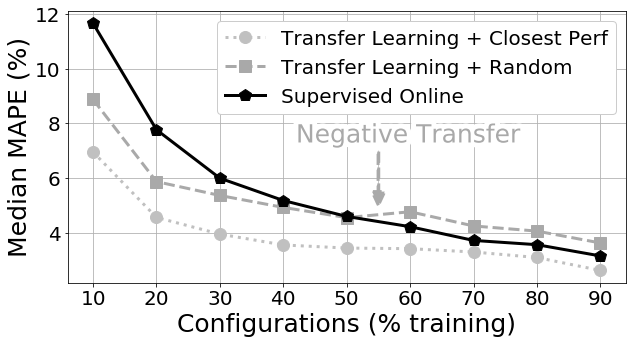

In [128]:
fig = plt.figure(figsize = (10, 5))
axs =fig.add_subplot(111)

linestyles = ['dotted', 'dashed', 'solid']
colors = ["silver", "darkgray", "black"]
markers = ['o', 's', 'p', 'x']

axs.plot(prop_train_config, res_tl_perf, linewidth=3, linestyle = linestyles[0], c= colors[0],
                            marker = markers[0], markersize = 12, 
         label="Transfer Learning + Closest Perf", color=colors[0])
axs.plot(prop_train_config, res_tl_rand, linewidth=3, linestyle = linestyles[1], c= colors[1],
                            marker = markers[1], markersize = 12, 
         label="Transfer Learning + Random", color=colors[1])
axs.plot(prop_train_config, res_online, linewidth=3, linestyle = linestyles[2], c= colors[2],
                            marker = markers[2], 
         markersize = 12, label="Supervised Online")
axs.set_title("", fontsize =15)
axs.grid(axis="both")
axs.legend(fontsize=20, loc = 'upper right', framealpha=1)
axs.set_xlabel("Configurations (% training)", size = 25)
axs.set_ylabel("Median MAPE (%)", size = 25)
axs.set_xticklabels([10*k for k in range(0, 10)])

# Arrow
plt.arrow(x = 0.55, y = 7, dx= 0, dy = -1.5, head_width = 0.02, head_length = .5, 
          color="darkgray", linewidth = 3, linestyle = 'dashed', zorder = 5)
plt.text(s = "Negative Transfer", x = 0.42, y = 7.3, 
         size = 25, color = 'darkgray',
         path_effects=[pe.withStroke(linewidth=10, foreground="white")], zorder = 5)

plt.xticks(size = 20)
plt.yticks(size = 20)
plt.savefig("../results/RQ4_eval_1.png", bbox_inches='tight', dpi =300)
plt.show()